In [1]:
import numpy as np
import pandas as pd
import sklearn
from matplotlib import pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense, Dropout
from sklearn.preprocessing import MinMaxScaler
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import GridSearchCV
import tensorflow as tf


In [2]:
# 预处理输入数据
def preprocessing(nmp_df,power_df):
    nmp_df.head(10)
    power_df.head(10)
    fix_df=pd.merge(nmp_df, power_df, on=['Datetime'], how='left')
    fix_df.head(10)
    fix_df.describe()

    return fix_df

In [3]:
# 读取数据
his_nmp_gf_df = pd.read_csv('.\\data\\GF001\\03 His_NWP_GF.csv',parse_dates=["Datetime"],index_col=[0])
his_power_gf_df = pd.read_csv('.\\data\\GF001\\02 His_Power_GF.csv',parse_dates=["Datetime"],index_col=[0])
his_gf_df=preprocessing(his_nmp_gf_df,his_power_gf_df)
his_gf_df.to_csv('his_gf.csv',encoding = 'utf-8') #存储合并后数据

In [4]:
df=pd.read_csv('his_gf.csv',parse_dates=["Datetime"],index_col=[0])
df.head()

Irradiance  Speed10  Direction10  Temper  Pressure  \
Datetime                                                                  
2022-06-13 00:00:00         0.0   6.9614      14.8148   27.32    998.67   
2022-06-13 00:15:00         0.0   7.0349      15.1623   27.33    998.68   
2022-06-13 00:30:00         0.0   7.1234      14.3874   27.31    998.54   
2022-06-13 00:45:00         0.0   7.2816      15.6968   27.29    998.21   
2022-06-13 01:00:00         0.0   7.2544      18.7347   27.34    997.92   

                     Humidity  Power(MW)  
Datetime                                  
2022-06-13 00:00:00     92.59        0.0  
2022-06-13 00:15:00     92.40        0.0  
2022-06-13 00:30:00     92.42        0.0  
2022-06-13 00:45:00     92.27        0.0  
2022-06-13 01:00:00     91.92        0.0

In [5]:
df.drop('Pressure', axis=1, inplace=True)

In [6]:
df.tail()

Irradiance  Speed10  Direction10  Temper  Humidity  \
Datetime                                                                  
2022-06-19 22:45:00         0.0   8.8735       7.3813   27.97     91.88   
2022-06-19 23:00:00         0.0   7.6355     357.8234   27.16      0.00   
2022-06-19 23:15:00         0.0   7.0539     352.9153   27.19      0.00   
2022-06-19 23:30:00         0.0   6.7206     350.5797   27.27      0.00   
2022-06-19 23:45:00         0.0   7.0146     352.2164   27.27      0.00   

                     Power(MW)  
Datetime                        
2022-06-19 22:45:00        0.0  
2022-06-19 23:00:00        0.0  
2022-06-19 23:15:00        0.0  
2022-06-19 23:30:00        0.0  
2022-06-19 23:45:00        0.0

In [7]:
df.shape

(672, 6)

In [8]:
df_feaformm=pd.read_csv('.\\data\\GF001\\04 Fore_NWP_GF.csv',parse_dates=["Datetime"],index_col=[0])
df_feaformm.drop('Pressure', axis=1, inplace=True)
df_feaformm.tail(10)

Irradiance  Speed10  Direction10  Temper  Humidity
Datetime                                                               
2022-07-21 21:30:00         0.0   3.8147      40.7479   27.76     80.12
2022-07-21 21:45:00         0.0   3.8006      40.7321   27.73     80.43
2022-07-21 22:00:00         0.0   3.8118      41.3839   27.69     80.75
2022-07-21 22:15:00         0.0   3.9306      41.8030   27.67     80.87
2022-07-21 22:30:00         0.0   4.0743      41.3182   27.65     80.98
2022-07-21 22:45:00         0.0   4.3397      40.7015   27.68     80.90
2022-07-21 23:00:00         0.0   4.4797      41.0175   27.65      0.00
2022-07-21 23:15:00         0.0   3.7592      38.3028   27.33      0.00
2022-07-21 23:30:00         0.0   3.8079      39.4588   27.38      0.00
2022-07-21 23:45:00         0.0   3.7659      40.5848   27.33      0.00

In [9]:
# 划分train valid test集
gf_df_train = df[:int(0.6*len(df))]
gf_df_valid = df[int(0.6*len(df)):int(0.8*len(df))]
gf_df_test =df[int(0.8*len(df))-7:]

In [10]:
gf_df_test.head(10)

Irradiance  Speed10  Direction10  Temper  Humidity  \
Datetime                                                                  
2022-06-18 12:30:00      717.06   8.6133      26.6245   29.35     82.42   
2022-06-18 12:45:00      588.22   8.5734      26.0869   29.19     83.03   
2022-06-18 13:00:00      531.92   8.5708      25.2794   29.10     83.67   
2022-06-18 13:15:00      475.16   8.5900      24.9242   29.00     84.12   
2022-06-18 13:30:00      539.46   8.6055      24.5101   29.07     84.16   
2022-06-18 13:45:00      631.80   8.5547      23.4185   29.20     83.64   
2022-06-18 14:00:00      620.64   8.5071      21.2261   29.22     83.36   
2022-06-18 14:15:00      660.03   8.4976      19.0959   29.24     83.62   
2022-06-18 14:30:00      704.20   8.5351      18.1590   29.27     83.67   
2022-06-18 14:45:00      645.89   8.5928      17.6126   29.20     83.86   

                     Power(MW)  
Datetime                        
2022-06-18 12:30:00    61.2424  
2022-06-18 12:45:00    59.6648  
2022-06-18 13:00:00    62.3017  
2022-06-18 13:15:00    59.3981  
2022-06-18 13:30:00    60.3202  
2022-06-18 13:45:00    61.5091  
2022-06-18 14:00:00    55.7019  
2022-06-18 14:15:00    56.6240  
2022-06-18 14:30:00    56.0982  
2022-06-18 14:45:00    51.8761

In [11]:
gf_df_test_copy=gf_df_test.copy()
full_df_fea=gf_df_test_copy.append(df_feaformm)
full_df_fea.to_csv('full_df_fea.csv',encoding = 'utf-8')
full_df_fea

C:\Users\23966\AppData\Local\Temp\ipykernel_15740\3707190378.py:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  full_df_fea=gf_df_test_copy.append(df_feaformm)


Irradiance  Speed10  Direction10  Temper  Humidity  \
Datetime                                                                  
2022-06-18 12:30:00      717.06   8.6133      26.6245   29.35     82.42   
2022-06-18 12:45:00      588.22   8.5734      26.0869   29.19     83.03   
2022-06-18 13:00:00      531.92   8.5708      25.2794   29.10     83.67   
2022-06-18 13:15:00      475.16   8.5900      24.9242   29.00     84.12   
2022-06-18 13:30:00      539.46   8.6055      24.5101   29.07     84.16   
...                         ...      ...          ...     ...       ...   
2022-07-21 22:45:00        0.00   4.3397      40.7015   27.68     80.90   
2022-07-21 23:00:00        0.00   4.4797      41.0175   27.65      0.00   
2022-07-21 23:15:00        0.00   3.7592      38.3028   27.33      0.00   
2022-07-21 23:30:00        0.00   3.8079      39.4588   27.38      0.00   
2022-07-21 23:45:00        0.00   3.7659      40.5848   27.33      0.00   

                     Power(MW)  
Datetime                        
2022-06-18 12:30:00    61.2424  
2022-06-18 12:45:00    59.6648  
2022-06-18 13:00:00    62.3017  
2022-06-18 13:15:00    59.3981  
2022-06-18 13:30:00    60.3202  
...                        ...  
2022-07-21 22:45:00        NaN  
2022-07-21 23:00:00        NaN  
2022-07-21 23:15:00        NaN  
2022-07-21 23:30:00        NaN  
2022-07-21 23:45:00        NaN  

[814 rows x 6 columns]

In [12]:
gf_df_train

Irradiance  Speed10  Direction10  Temper  Humidity  \
Datetime                                                                  
2022-06-13 00:00:00         0.0   6.9614      14.8148   27.32     92.59   
2022-06-13 00:15:00         0.0   7.0349      15.1623   27.33     92.40   
2022-06-13 00:30:00         0.0   7.1234      14.3874   27.31     92.42   
2022-06-13 00:45:00         0.0   7.2816      15.6968   27.29     92.27   
2022-06-13 01:00:00         0.0   7.2544      18.7347   27.34     91.92   
...                         ...      ...          ...     ...       ...   
2022-06-17 03:30:00         0.0   6.4324      19.0546   27.67     90.43   
2022-06-17 03:45:00         0.0   6.4961      19.3275   27.65     90.19   
2022-06-17 04:00:00         0.0   6.4812      19.7490   27.62     90.29   
2022-06-17 04:15:00         0.0   6.6037      19.3678   27.64     90.07   
2022-06-17 04:30:00         0.0   6.7927      18.8084   27.67     89.65   

                     Power(MW)  
Datetime                        
2022-06-13 00:00:00        0.0  
2022-06-13 00:15:00        0.0  
2022-06-13 00:30:00        0.0  
2022-06-13 00:45:00        0.0  
2022-06-13 01:00:00        0.0  
...                        ...  
2022-06-17 03:30:00        0.0  
2022-06-17 03:45:00        0.0  
2022-06-17 04:00:00        0.0  
2022-06-17 04:15:00        0.0  
2022-06-17 04:30:00        0.0  

[403 rows x 6 columns]

In [13]:
df_copy=df.copy()

In [14]:
mm_df=df_copy.append(df_feaformm)
mm_df

C:\Users\23966\AppData\Local\Temp\ipykernel_15740\3652032022.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mm_df=df_copy.append(df_feaformm)


Irradiance  Speed10  Direction10  Temper  Humidity  \
Datetime                                                                  
2022-06-13 00:00:00         0.0   6.9614      14.8148   27.32     92.59   
2022-06-13 00:15:00         0.0   7.0349      15.1623   27.33     92.40   
2022-06-13 00:30:00         0.0   7.1234      14.3874   27.31     92.42   
2022-06-13 00:45:00         0.0   7.2816      15.6968   27.29     92.27   
2022-06-13 01:00:00         0.0   7.2544      18.7347   27.34     91.92   
...                         ...      ...          ...     ...       ...   
2022-07-21 22:45:00         0.0   4.3397      40.7015   27.68     80.90   
2022-07-21 23:00:00         0.0   4.4797      41.0175   27.65      0.00   
2022-07-21 23:15:00         0.0   3.7592      38.3028   27.33      0.00   
2022-07-21 23:30:00         0.0   3.8079      39.4588   27.38      0.00   
2022-07-21 23:45:00         0.0   3.7659      40.5848   27.33      0.00   

                     Power(MW)  
Datetime                        
2022-06-13 00:00:00        0.0  
2022-06-13 00:15:00        0.0  
2022-06-13 00:30:00        0.0  
2022-06-13 00:45:00        0.0  
2022-06-13 01:00:00        0.0  
...                        ...  
2022-07-21 22:45:00        NaN  
2022-07-21 23:00:00        NaN  
2022-07-21 23:15:00        NaN  
2022-07-21 23:30:00        NaN  
2022-07-21 23:45:00        NaN  

[1344 rows x 6 columns]

In [15]:
# 对数据进行归一化处理
scaler = MinMaxScaler(feature_range=(0,1))
scaler = scaler.fit(mm_df)
df_for_training_scaled = scaler.transform(gf_df_train)
df_for_validing_scaled=scaler.transform(gf_df_valid)
df_for_testing_scaled=scaler.transform(gf_df_test)

In [16]:
# 分离x与y
def createXY(array, days_used_to_train=7):
    features = list()
    labels = list()

    for i in range(days_used_to_train, len(array)):
        features.append(array[i-days_used_to_train:i, :])
        labels.append(array[i, -1])
    return np.array(features), np.array(labels)

train_X,train_y=createXY(df_for_training_scaled)
valid_X,valid_y=createXY(df_for_validing_scaled)
test_X,test_y=createXY(df_for_testing_scaled)

In [17]:
df_X,df_y=createXY(np.array(df))

In [18]:
train_X.shape

(396, 7, 6)

In [19]:
train_y.shape

(396,)

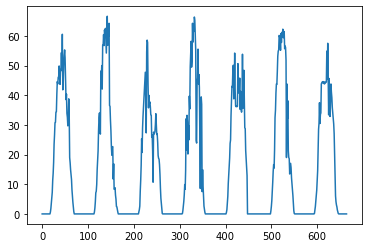

In [20]:
# 看一下历史波形
plt.plot(range(len(df_y)), df_y, label='history')

In [21]:
# 定义一个新的评价函数
def ev(y_true, y_predict):
    difference=(abs(np.array(y_true) - np.array(y_predict.flatten()))).sum()
    return float(difference) 

In [22]:
# 建立模型函数
def build_model(size):
    tf.random.set_seed(1) #设置随机数种子
    # Create grid_model
    grid_model = tf.keras.Sequential()
    grid_model.add(tf.keras.layers.LSTM(units=64))
    grid_model.add(tf.keras.layers.Dense(size))
    grid_model.add(tf.keras.layers.Dense(size))
    grid_model.add(tf.keras.layers.Dense(1))

    # Compile the grid_model
    grid_model.compile(
    optimizer='adam',
    loss='mse')
    
    return grid_model

In [23]:
# 准备一些copy用用
df_for_testing_scaled_1=df_for_testing_scaled.copy()
df_for_testing_scaled_inloop=df_for_testing_scaled.copy()
# df_for_validing_scaled_inloop=df_for_validing_scaled.copy()
df_for_testing_scaled_1=pd.DataFrame(df_for_testing_scaled_1)
df_for_testing_scaled_inloop=pd.DataFrame(df_for_testing_scaled_inloop)
# df_for_validing_scaled_inloop=pd.DataFrame(df_for_validing_scaled_inloop)
df_for_testing_scaled_1_array=df_for_testing_scaled_1.values
df_for_testing_scaled_inloop_array=df_for_testing_scaled_inloop.values
df_for_testing_scaled_inloop.iloc[7:,-1]=np.nan
df_for_testing_scaled_inloop

0         1         2         3         4         5
0    0.826306  0.861593  0.072576  0.751445  0.825852  0.918715
1    0.677837  0.857542  0.071080  0.720617  0.831964  0.895049
2    0.612959  0.857278  0.068833  0.703276  0.838377  0.934606
3    0.547552  0.859227  0.067844  0.684008  0.842886  0.891049
4    0.621648  0.860801  0.066692  0.697495  0.843287  0.904881
..        ...       ...       ...       ...       ...       ...
137  0.000000  0.888011  0.019027  0.485549  0.920641       NaN
138  0.000000  0.762316  0.994217  0.329480  0.000000       NaN
139  0.000000  0.703265  0.980559  0.335260  0.000000       NaN
140  0.000000  0.669425  0.974060  0.350674  0.000000       NaN
141  0.000000  0.699275  0.978615  0.350674  0.000000       NaN

[142 rows x 6 columns]

In [24]:
df_for_testing_scaled_inloop.to_csv('df_for_testing_scaled_inloop2.csv',encoding = 'utf-8') #存储合并后数据

In [25]:
# # 准备一些copy用用
# df_for_testing_scaled_1=df_for_testing_scaled.copy()
# df_for_testing_scaled_inloop=df_for_testing_scaled.copy()
# df_for_validing_scaled_inloop=df_for_validing_scaled.copy()
# df_for_testing_scaled_1=pd.DataFrame(df_for_testing_scaled_1)
# df_for_testing_scaled_inloop=pd.DataFrame(df_for_testing_scaled_inloop)
# df_for_validing_scaled_inloop=pd.DataFrame(df_for_validing_scaled_inloop)
# test_y=df_for_testing_scaled_1.iloc[:,-1:]
# print(len(test_y))
# test_y
# df_for_testing_scaled_inloop.iloc[:,-1]=0
# df_7pieces_from_valid=df_for_validing_scaled_inloop.iloc[-7:,:]
# df_7pieces_from_valid
# full_df_test=df_7pieces_from_valid.append(df_for_testing_scaled_inloop)
# full_df_test.head(10)
# full_df_test.index = range(0,len(full_df_test))
# full_df_test
# full_df_test_forpred=full_df_test.copy()
# df_for_testing_scaled_1_array=df_for_testing_scaled_1.values
# df_for_testing_scaled_inloop_array=df_for_testing_scaled_inloop.values
# full_df_test_array=full_df_test.values
# full_df_test_forpred_array=full_df_test_forpred.values

In [26]:
# 为循环初始化一些数据
bestscore=1000
flag=0
num=0
best_size=0
best_batch_size=0
best_epochs=0
time_step=7


In [27]:
# df_for_testing_scaled_inloop.head(10)

In [28]:
# df_for_testing_scaled_inloop.iloc[7:,-1]=np.nan

In [29]:
# df_for_testing_scaled_inloop.head(10)

In [30]:
# # 开始循环（warning不影响做）
# for size in [32]:
#     for batch_size in [16]:
#         for epochs in [30,40,50,60]:
#             grid_model=build_model(size)
#             grid_model.fit(
#             train_X, train_y,
#             validation_data=(valid_X, valid_y),
#             batch_size=32,
#             epochs=epochs,
#             verbose=0)
#             all_data_test=[]
# # 此处用了和feature一样的逐点预测方法
#             for i in range (time_step,len(full_df_test_array)) :
#                  data_x=[]
#                  data_x.append( full_df_test_array[i-time_step :i , 0:full_df_test.shape[1]])
#                  data_x=np.array(data_x)
#                  prediction=grid_model.predict(data_x,verbose=0)
#                  if prediction<0:
#                     prediction=0
#                  all_data_test.append(prediction)
#                  full_df_test.iloc[i,-1]=prediction
#             score=ev(test_y,np.array(all_data_test))
#             print('num:',num,'score=',score,'size=',size,'batch_size=',batch_size,'epochs=',epochs,)
#             num=num+1
#             if score<bestscore:
#                 flag=1
#                 bestscore=score
#                 print(bestscore)
#                 best_size=size
#                 best_batch_size=batch_size
#                 best_epochs=epochs
#                 # Export the model to a SavedModel
#                 grid_model.save('keras_model_tf_version', save_format='tf')
# print(bestscore,'best_size=',best_size,'best_batch_size=',best_batch_size,'best_epochs=',best_epochs)

In [ ]:
# 开始循环（warning不影响做）
for size in [8]:
    for batch_size in [32]:
        for epochs in [30]:
            grid_model=build_model(size)
            grid_model.fit(
            train_X, train_y,
            validation_data=(valid_X, valid_y),
            batch_size=32,
            epochs=epochs,
            verbose=0)
            all_data_test=[]
# 此处用了和feature一样的逐点预测方法
            for i in range (time_step,len(df_for_testing_scaled_inloop_array)) :
                 data_x=[]
                 data_x.append( df_for_testing_scaled_inloop_array[i-time_step :i , 0:df_for_testing_scaled_inloop.shape[1]])
                 data_x=np.array(data_x)
                 prediction=grid_model.predict(data_x,verbose=0)
                 if prediction<0:
                    prediction=0
                 all_data_test.append(prediction)
                 df_for_testing_scaled_inloop.iloc[i,-1]=prediction
            score=ev(test_y,np.array(all_data_test))
            print('num:',num,'score=',score,'size=',size,'batch_size=',batch_size,'epochs=',epochs,)
            num=num+1
            if score<bestscore:
                flag=1
                bestscore=score
                print(bestscore)
                best_size=size
                best_batch_size=batch_size
                best_epochs=epochs
                # Export the model to a SavedModel
                grid_model.save('keras_model_tf_version', save_format='tf')
print(bestscore,'best_size=',best_size,'best_batch_size=',best_batch_size,'best_epochs=',best_epochs)

In [ ]:
df_for_testing_scaled_inloop.head(20)

In [ ]:
# 加载最佳模型
my_model = tf.keras.models.load_model('keras_model_tf_version')

In [ ]:
# 用最佳模型预测一下test
all_data_test=[]
for i in range (time_step,len(df_for_testing_scaled_1_array)) :
                 data_x=[]
                 data_x.append( df_for_testing_scaled_1_array[i-time_step :i , 0:df_for_testing_scaled_1.shape[1]])
                 data_x=np.array(data_x)
                 prediction=my_model.predict(data_x,verbose=0)
                 if prediction<0:
                    prediction=0
                 all_data_test.append(prediction)
                 df_for_testing_scaled_1.iloc[i,-1]=prediction

In [ ]:
ev(test_y,np.array(all_data_test))

In [ ]:
# 看看test的结果
plt.plot(range(len(all_data_test)), all_data_test, label='Prediction')
plt.plot(range(len(test_y)), test_y, label='Prediction')

In [ ]:
# Recreate the exact same model
new_pred_valid_y=my_model.predict(valid_X)
ev(valid_y,new_pred_valid_y)

In [ ]:
# 查看valid集预测结果
pred_valid_y = my_model.predict(valid_X)
plt.plot(range(len(pred_valid_y)), pred_valid_y, label='Prediction')
plt.plot(range(len(pred_valid_y)), valid_y, label='Ground Truth')
plt.fill_between(range(len(pred_valid_y)), pred_valid_y.flatten(), valid_y.flatten(), color='MistyRose',label='error')
plt.xlabel('Amount of samples')
plt.ylabel('Prediction')
plt.legend()
plt.show()

In [ ]:
ev(valid_y,pred_valid_y)

In [ ]:
df_fea=pd.read_csv('full_df_fea.csv',index_col=[0])
df_fea

In [ ]:
df_fea_array=df_fea.values

In [ ]:
# 用最佳模型预测一下fea
all_data_fea=[]
for i in range (time_step,len(df_fea_array)) :
                 data_x=[]
                 data_x.append( df_fea_array[i-time_step :i , 0:df_fea.shape[1]])
                 data_x=np.array(data_x)
                 prediction=my_model.predict(data_x,verbose=0)
                 if prediction<0:
                    prediction=0
                 all_data_fea.append(prediction)
                 df_fea.iloc[i,-1]=prediction

In [ ]:
plt.plot(range(len(all_data_fea)), all_data_fea, label='Prediction')